In [1]:
import netStandalone
import os
import numpy as np
from schmidt import BaseElement
from utils import plotter as plt
import time

In [2]:
# Path de workspace
#PATH = os.path.join(os.environ['USERPROFILE'], "Desktop/CE")
PATH = "D:/DiegoRemirez/Desktop/CE/"

# Paso de integración para los productos escalares
step = 0.1
# Dominio de las funciones [-domaine,domaine]
domaine = 128
# Orden, para distribuir los bias se va dividiendo el dominio de dos en dos -> 2^order neuronas base
order = 5

In [3]:
# Genera las funciones
X = np.arange(-domaine,domaine,step)

yfunc = np.zeros(int(2*domaine/step))
yfunc = np.abs(np.arange(-domaine,domaine,step)/10+1)#np.sin(np.arange(-domaine,domaine,step)/10)+1
myElement = BaseElement.myfunc(yfunc)

In [4]:
# Guarda las funciones en archivo
with open(PATH+"_temporal_data.csv", "w") as file:
    file.write("//number of elements\n"+str(len(yfunc))+",\n\n")
    file.write("//output isze, input size\n"+str(1)+","+str(1)+",\n\n")
    file.write("//inputs\n")
    for x in X:
        file.write(str(x)+",")
    file.write("\n//outputs\n")
    for y in yfunc:
        file.write(str(y)+",")
    file.write("\n//labels\n")
    for y in yfunc:
        file.write(str(0)+",")

In [5]:
# Crea la base de proyeccion
myBase = BaseElement.base(step, domaine, order)

In [6]:
# Escribe una red con las funciones proyectadas
entradas = 1
npl = [myBase.max_index,1]
act = [netStandalone.RELU2, netStandalone.RELU2]
myBase.write_params(PATH+"/pyparams.csv",entradas,npl,[myElement])

### VITIATE

In [7]:
# Inicializa el manejador de redes
handler = netStandalone.handler(PATH)
ITERATIONS = 10000


In [8]:
handler.instantiate("red_proyectada", netStandalone.CPU)
handler.set_active_net("red_proyectada")
handler.build_net_from_file("pyparams",netStandalone.RELOAD_FILE)
handler.attr(netStandalone.ALPHA, 0.01)
handler.attr(netStandalone.ALPHA_DECAY, 0.0001)
handler.attr(netStandalone.ERROR_THRESHOLD, 0.01)
handler.attr(netStandalone.BATCH_SIZE, len(X))
handler.attr(netStandalone.EPOCHS, ITERATIONS)

In [9]:
tic = time.perf_counter()
handler.run_gradient(file=PATH+"_temporal_data.csv", file_reload=netStandalone.RELOAD_FILE)
tiempo_proyectada = time.perf_counter()-tic #handler.get_gradient_performance()#
print("Tiempo proyectada: "+str(tiempo_proyectada))


Tiempo proyectada: 0.000251900000002081


Error: 54614.29003906357


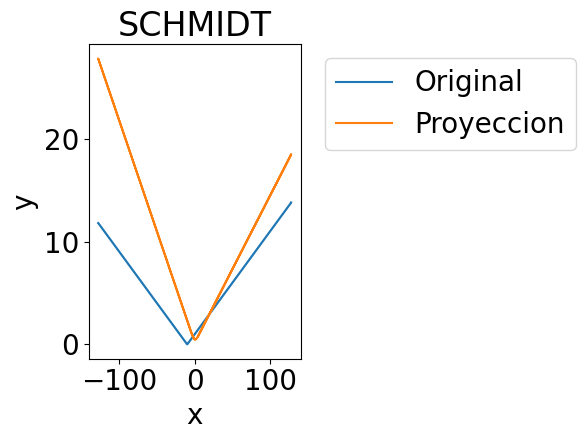

In [86]:
Y = []
for x in X:
    test_input = netStandalone.v_float([x])
    Y.append(handler.run_forward(test_input))

print("Error: "+str(np.sum(np.abs(Y[0]-yfunc))))
args = {'title': "SCHMIDT",'x_label': "x", 'y_label': "y", 'label': ["Original", "Proyeccion"]}
plt.multiple_plot(X, [yfunc,Y],args)

In [83]:
handler.instantiate("red_aleatoria", netStandalone.CPU)
handler.set_active_net("red_aleatoria")
handler.build_net_from_data(entradas,netStandalone.v_int([myBase.max_index,myBase.max_index,1]),netStandalone.v_int([netStandalone.RELU2,netStandalone.RELU2, netStandalone.RELU2]))

handler.attr(netStandalone.ALPHA, 0.01)
handler.attr(netStandalone.ALPHA_DECAY, 0.0001)
handler.attr(netStandalone.ERROR_THRESHOLD, 0.01)
handler.attr(netStandalone.BATCH_SIZE, len(X))
handler.attr(netStandalone.EPOCHS, 5000*ITERATIONS)

v_float[-1]
Tiempo aleatoria: 0.0005670999998983461


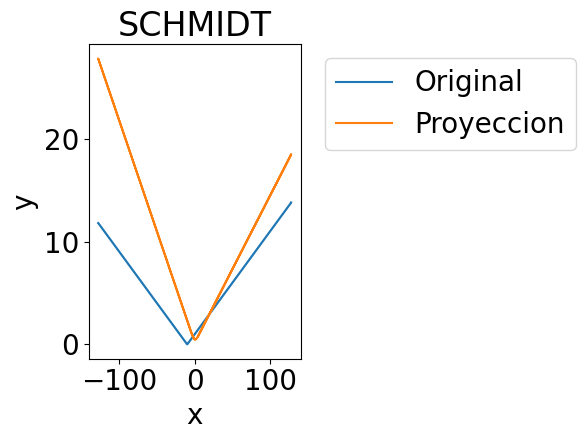

In [87]:
tic = time.perf_counter()
v= handler.run_gradient(file=PATH+"_temporal_data.csv", file_reload=netStandalone.RELOAD_FILE)
tiempo_aleatoria = time.perf_counter()-tic #handler.get_gradient_performance()#
print("Tiempo aleatoria: "+str(tiempo_aleatoria))
Y = []
for x in X:
    test_input = netStandalone.v_float([x])
    Y.append(handler.run_forward(test_input))

args = {'title': "SCHMIDT",'x_label': "x", 'y_label': "y", 'label': ["Original", "Proyeccion"]}
plt.multiple_plot(X, [yfunc,Y],args)

In [48]:
(tiempo_aleatoria-tiempo_proyectada)/tiempo_proyectada*100

12.631578942673752